In [12]:

!pip install qulacs


In [14]:
# imports and RNG
import numpy as np
import os
from itertools import combinations
from sklearn import datasets
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from qulacs import QuantumState, QuantumCircuit
import qulacs.gate as gate
from scipy.optimize import minimize

np.random.seed(42)


In [15]:
# dataset prep (binary Iris) and standardization
iris = datasets.load_iris()
X = iris.data.copy()   # shape (150,4)
y = iris.target.copy()

# Binary classification: keep only classes 0 and 1 (drop class 2)
mask = (y == 0) | (y == 1)
X = X[mask]
y = y[mask]

d = X.shape[1]  # number of features (qubits)
print(f"Samples: {X.shape[0]}, Features (d): {d}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Samples: 100, Features (d): 4


In [16]:
# compute classical validation loss for every feature subset
def evaluate_subset_loss(X, y, feature_idx_tuple, cv_folds=5, random_state=42):
    """Return loss = 1 - mean_accuracy for selected features (or 1.0 if empty)."""
    if len(feature_idx_tuple) == 0:
        return 1.0
    X_sub = X[:, list(feature_idx_tuple)]
    clf = LogisticRegression(solver='liblinear', random_state=random_state)
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X_sub, y, cv=cv, scoring='accuracy')
    return 1.0 - scores.mean()

num_states = 2 ** d
subset_list = []
loss_list = np.zeros(num_states)
for s in range(num_states):
    bits = [(s >> i) & 1 for i in range(d)]
    idxs = tuple(i for i, b in enumerate(bits) if b == 1)
    subset_list.append(idxs)
    loss_list[s] = evaluate_subset_loss(X_scaled, y, idxs)

# Add small penalty proportional to number of features to prefer compact subsets
lambda_penalty = 0.02
penalty = np.array([lambda_penalty * sum(subset_list[s]) for s in range(num_states)])
cost_values = loss_list + penalty

print("Computed classical costs for all subsets.")
print("Example (index, subset, loss, penalty, total cost):")
for s in range(min(8, num_states)):
    print(s, subset_list[s], f"{loss_list[s]:.3f}", f"{penalty[s]:.3f}", f"{cost_values[s]:.3f}")

print("\nClassical best subsets by cost:")
best_idx = np.argsort(cost_values)[:5]
for idx in best_idx:
    print(idx, subset_list[idx], "cost=", cost_values[idx])


Computed classical costs for all subsets.
Example (index, subset, loss, penalty, total cost):
0 () 1.000 0.000 1.000
1 (0,) 0.120 0.000 0.120
2 (1,) 0.160 0.020 0.180
3 (0, 1) 0.010 0.020 0.030
4 (2,) 0.000 0.040 0.040
5 (0, 2) 0.000 0.040 0.040
6 (1, 2) 0.000 0.060 0.060
7 (0, 1, 2) 0.000 0.060 0.060

Classical best subsets by cost:
3 (0, 1) cost= 0.03000000000000001
4 (2,) cost= 0.04
5 (0, 2) cost= 0.04
6 (1, 2) cost= 0.06
7 (0, 1, 2) cost= 0.06


In [17]:
# QAOA primitives (prepare |+>^n, apply cost-phase, apply mixer)
def prepare_plus_state(n_qubits):
    state = QuantumState(n_qubits)
    circ = QuantumCircuit(n_qubits)
    for q in range(n_qubits):
        circ.add_gate(gate.H(q))
    circ.update_quantum_state(state)
    return state


def apply_mixer(state, beta):
    n = state.get_qubit_count()
    circ = QuantumCircuit(n)
    angle = 2.0 * beta   # as before
    for q in range(n):
        circ.add_gate(gate.RX(q, angle))
    circ.update_quantum_state(state)


def apply_cost_phase_by_amplitudes(state, gamma, cost_array):
    """
    Apply cost unitary U_C(gamma) by phase-multiplying each amplitude:
      |s> -> exp(-i * gamma * C_s) |s>
    cost_array must be length 2^n.
    """
    vec = state.get_vector()
    phases = np.exp(-1j * gamma * cost_array)
    vec *= phases  # modifies state in-place


In [18]:
# QAOA expectation and final probabilities
def qaoa_expectation(params, cost_array, p, n_qubits):
    """
    params: array length 2*p: [gamma0, beta0, gamma1, beta1, ...]
    returns expected cost <psi|C|psi>
    """
    state = prepare_plus_state(n_qubits)
    for layer in range(p):
        gamma = params[2*layer]
        beta = params[2*layer + 1]
        apply_cost_phase_by_amplitudes(state, gamma, cost_array)
        apply_mixer(state, beta)
    probs = np.abs(state.get_vector())**2
    return np.sum(probs * cost_array.real)

def qaoa_final_probs(params, cost_array, p, n_qubits):
    state = prepare_plus_state(n_qubits)
    for layer in range(p):
        gamma = params[2*layer]
        beta = params[2*layer + 1]
        apply_cost_phase_by_amplitudes(state, gamma, cost_array)
        apply_mixer(state, beta)
    return np.abs(state.get_vector())**2


In [19]:
# Run classical optimization for QAOA parameters
n_qubits = d
p = 2  # QAOA depth; try p=1 or p=2 for small problems
# initialize params: gamma ~ [0,pi], beta ~ [0,pi/2]
init_params = np.random.uniform(low=0.0, high=np.pi, size=2*p)

cost_array = cost_values.copy()

def objective(params):
    # minimize expected cost
    return qaoa_expectation(params, cost_array, p, n_qubits)

print("Starting classical optimization of QAOA parameters (this may take a minute)...")
res = minimize(objective, init_params, method='Nelder-Mead', options={'maxiter': 600, 'disp': True})
print("Optimization finished. success:", res.success)
print("Optimal params:", res.x)
print("Optimal expectation (cost):", res.fun)


Starting classical optimization of QAOA parameters (this may take a minute)...
Optimization terminated successfully.
         Current function value: 0.141250
         Iterations: 26
         Function evaluations: 88
Optimization finished. success: True
Optimal params: [1.14907469 3.02875835 2.31399946 1.95420755]
Optimal expectation (cost): 0.14124999999999974


In [20]:
# Inspect final probabilities and top subsets
opt_params = res.x
probs = qaoa_final_probs(opt_params, cost_array, p, n_qubits)

# sort by probability
sorted_idx = np.argsort(probs)[::-1]
print("Top states by probability after QAOA:")
for rank in range(min(6, len(sorted_idx))):
    s = sorted_idx[rank]
    print(f"Rank {rank+1}: state {s:0{n_qubits}b} -> subset {subset_list[s]} prob={probs[s]:.4f} cost={cost_array[s]:.4f}")

# Compare to classical best
best_classical_idx = np.argmin(cost_array)
print("\nClassical best subset index:", best_classical_idx, "subset:", subset_list[best_classical_idx], "cost:", cost_array[best_classical_idx])
print("Most probable QAOA subset:", subset_list[sorted_idx[0]])


Top states by probability after QAOA:
Rank 1: state 1111 -> subset (0, 1, 2, 3) prob=0.0625 cost=0.1200
Rank 2: state 1110 -> subset (1, 2, 3) prob=0.0625 cost=0.1200
Rank 3: state 1101 -> subset (0, 2, 3) prob=0.0625 cost=0.1000
Rank 4: state 1100 -> subset (2, 3) prob=0.0625 cost=0.1000
Rank 5: state 1011 -> subset (0, 1, 3) prob=0.0625 cost=0.0800
Rank 6: state 1010 -> subset (1, 3) prob=0.0625 cost=0.0900

Classical best subset index: 3 subset: (0, 1) cost: 0.03000000000000001
Most probable QAOA subset: (0, 1, 2, 3)


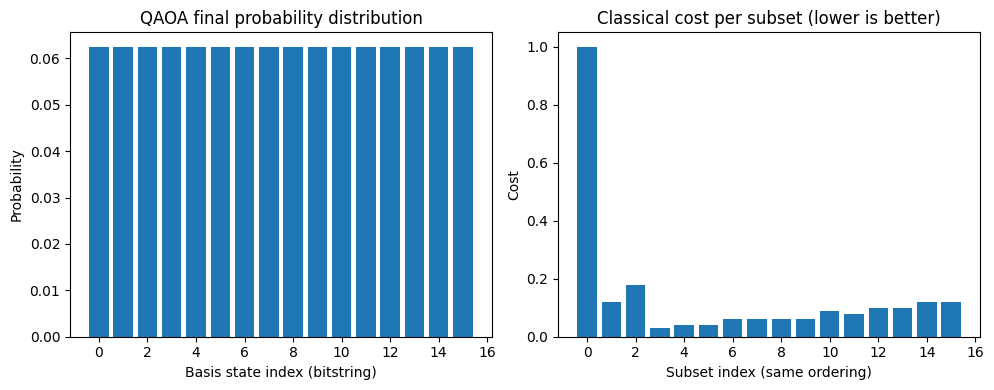

Saved optimized parameters to results/final_params.npy


In [21]:
# plots and saving results (create directories if needed)
os.makedirs("images", exist_ok=True)
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(range(len(probs)), probs)
plt.title("QAOA final probability distribution")
plt.xlabel("Basis state index (bitstring)")
plt.ylabel("Probability")
plt.subplot(1,2,2)
plt.bar(range(len(cost_array)), cost_array)
plt.title("Classical cost per subset (lower is better)")
plt.xlabel("Subset index (same ordering)")
plt.ylabel("Cost")
plt.tight_layout()
plt.savefig("images/qaoa_distribution_and_costs.png", dpi=150)
plt.show()

# Save final params
np.save("results/final_params.npy", opt_params)
print("Saved optimized parameters to results/final_params.npy")


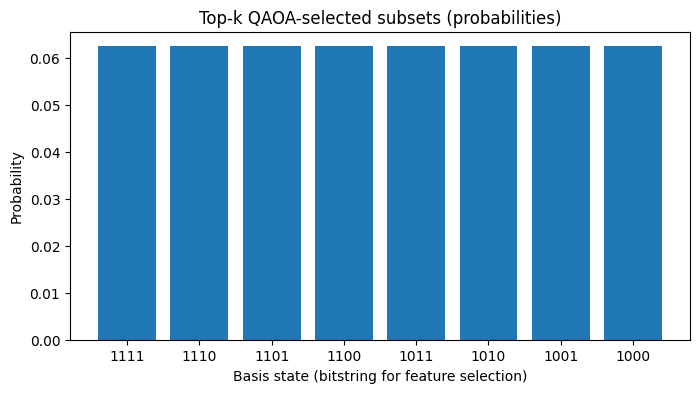

Top-k states with (subset, prob, cost):
1111 -> subset (0, 1, 2, 3) prob=0.0625 cost=0.1200
1110 -> subset (1, 2, 3) prob=0.0625 cost=0.1200
1101 -> subset (0, 2, 3) prob=0.0625 cost=0.1000
1100 -> subset (2, 3) prob=0.0625 cost=0.1000
1011 -> subset (0, 1, 3) prob=0.0625 cost=0.0800
1010 -> subset (1, 3) prob=0.0625 cost=0.0900
1001 -> subset (0, 3) prob=0.0625 cost=0.0600
1000 -> subset (3,) prob=0.0625 cost=0.0600


In [22]:
# optional (Not necessary to do, you can run it though): visualize top-k subsets with binary labels and costs
k = min(8, len(probs))
top = sorted_idx[:k]
labels = [f"{i:0{n_qubits}b}" for i in top]
vals = probs[top]
costs_top = cost_array[top]

plt.figure(figsize=(8,4))
plt.bar(range(k), vals)
plt.xticks(range(k), labels)
plt.title("Top-k QAOA-selected subsets (probabilities)")
plt.xlabel("Basis state (bitstring for feature selection)")
plt.ylabel("Probability")
plt.savefig("images/qaoa_topk.png", dpi=150)
plt.show()

print("Top-k states with (subset, prob, cost):")
for s in top:
    print(f"{s:0{n_qubits}b} -> subset {subset_list[s]} prob={probs[s]:.4f} cost={cost_array[s]:.4f}")
